In [1]:
import sys
sys.path.append('../../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from qick import *
from qick_training import *
from qick.averager_program import QickSweep
from qick.averager_program import merge_sweeps

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt

In [2]:
# Load bitstream with custom overlay
soc = QickSoc()
soccfg = soc

print(soccfg)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.175
	Firmware timestamp: Thu Feb 17 16:46:52 2022

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC ti

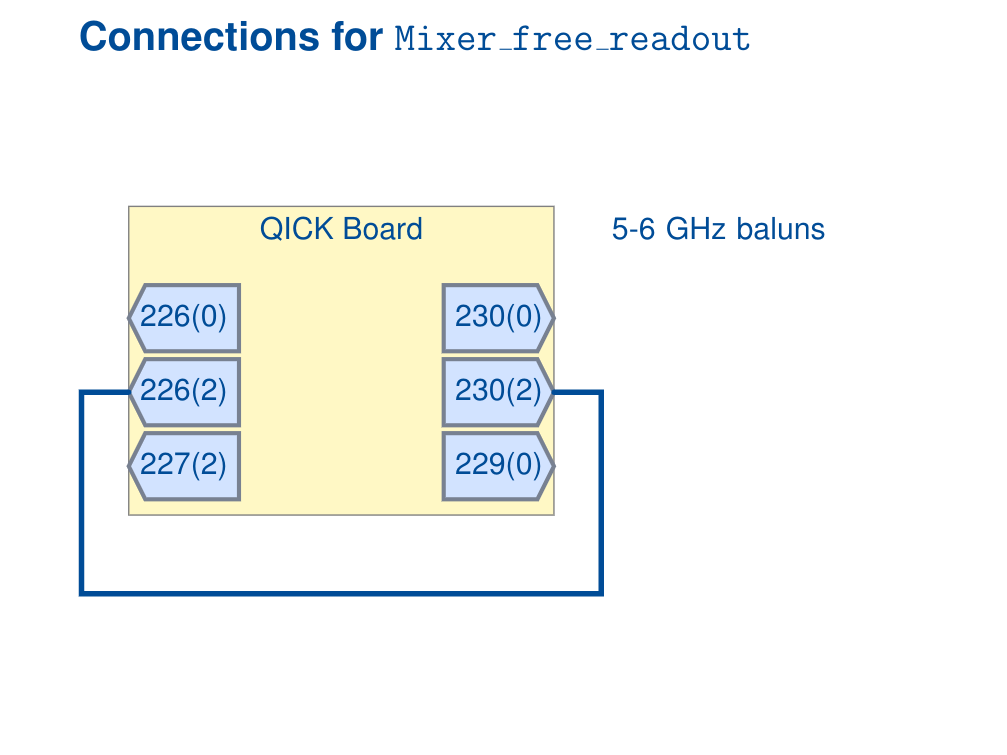

In [1]:
from IPython.display import Image, display
display(Image(filename='images/Connections_Mixer_free.png', embed=True))

# Mixer-free readout (test this with 5-6 GHz baluns)

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, '2 GHz, NQZ 1')

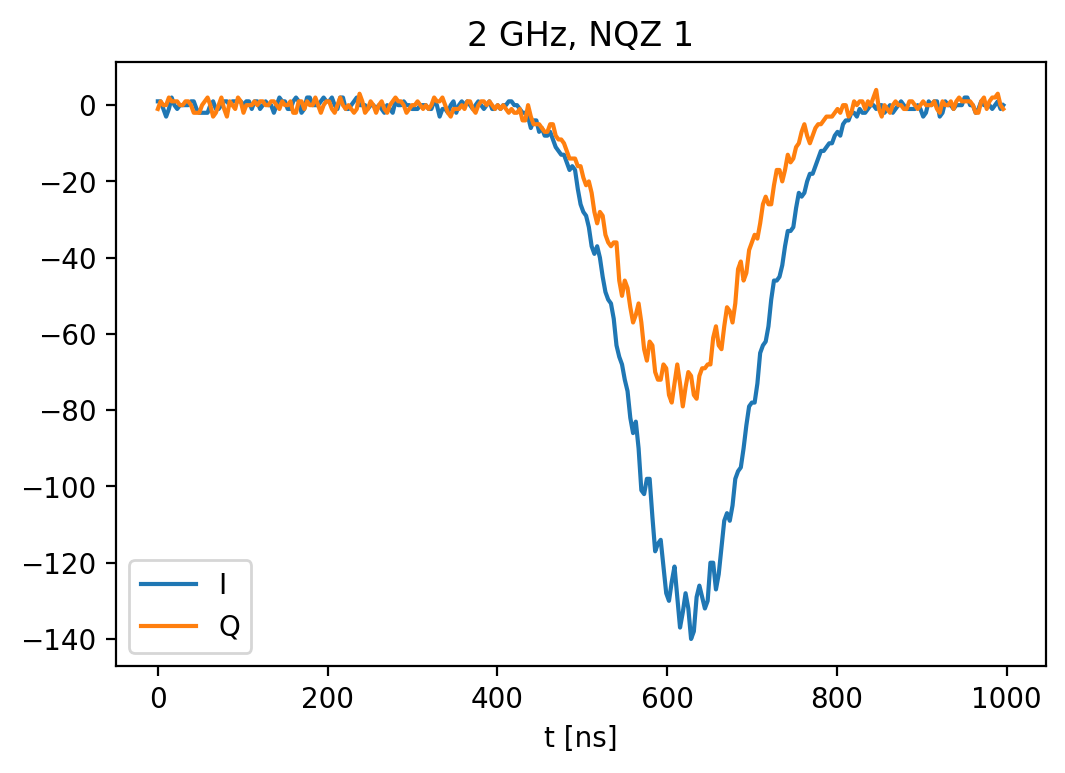

In [3]:
##########################################
### One generator/readout and raw-data ###
##########################################
class ReadoutTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=self.cfg["nqz"])
        
        # Declare Gaussian Envelope.
        sigma  = self.us2cycles(self.cfg['env_sigma'],gen_ch=self.cfg['gen_ch'])
        length = self.us2cycles(self.cfg['env_length'],gen_ch=self.cfg['gen_ch'])
        self.add_gauss(ch=self.cfg['gen_ch'], name=self.cfg['env_name'], sigma=sigma, length=length)        
        
        
        # DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'][0])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'], 
                                     style  = 'arb', 
                                     freq   = freq,
                                     gain   = self.cfg['pulse_gain'],
                                     waveform = self.cfg['env_name'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['pulse_freq'],
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phase=0, phrst=0, mode="oneshot")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.cfg['ro_ch'],
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [1],
        "ro_length"   : 1,
        "ro_offset"   : 0,
        
        "gen_ch"      : 2,        
        "pulse_length": 0.5,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 2000,
        "nqz"         : 1,
        
        "env_sigma"   : 0.1,
        "env_length"  : 0.4,
        "env_name"    : 'gauss',  
        
        "reps"        : 1,
       }

prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

# Plot Captured Data.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

yi = iq_list[0][0]
yq = iq_list[0][1]
x = ts*np.arange(len(iq_list[0][0]))

plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.legend(['I','Q']);  
plt.title("2 GHz, NQZ 1")

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, '2 GHz, NQZ 2')

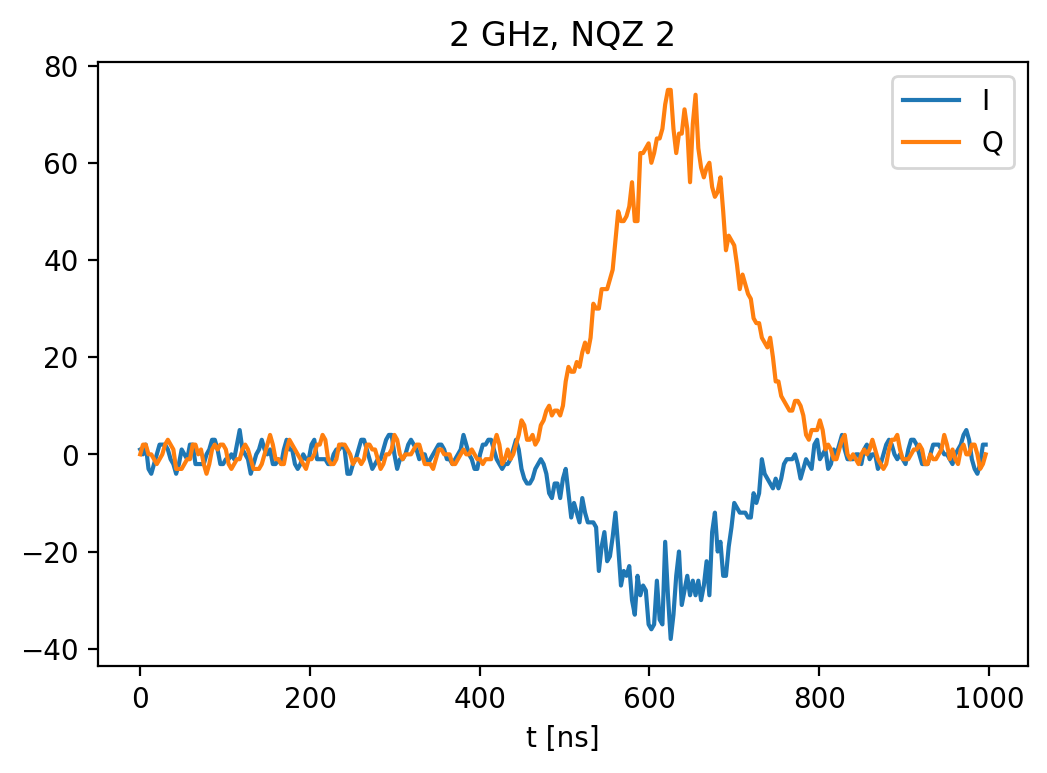

In [4]:
config={"ro_ch"       : [1],
        "ro_length"   : 1,
        "ro_offset"   : 0,
        
        "gen_ch"      : 2,        
        "pulse_length": 0.5,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 2000,
        "nqz"         : 2,
        
        "env_sigma"   : 0.1,
        "env_length"  : 0.4,
        "env_name"    : 'gauss',  
        
        "reps"        : 1,
       }


prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

# Plot Captured Data.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

yi = iq_list[0][0]
yq = iq_list[0][1]
x = ts*np.arange(len(iq_list[0][0]))

plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.legend(['I','Q']);  
plt.title("2 GHz, NQZ 2")

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, '8.5 GHz, NQZ 1')

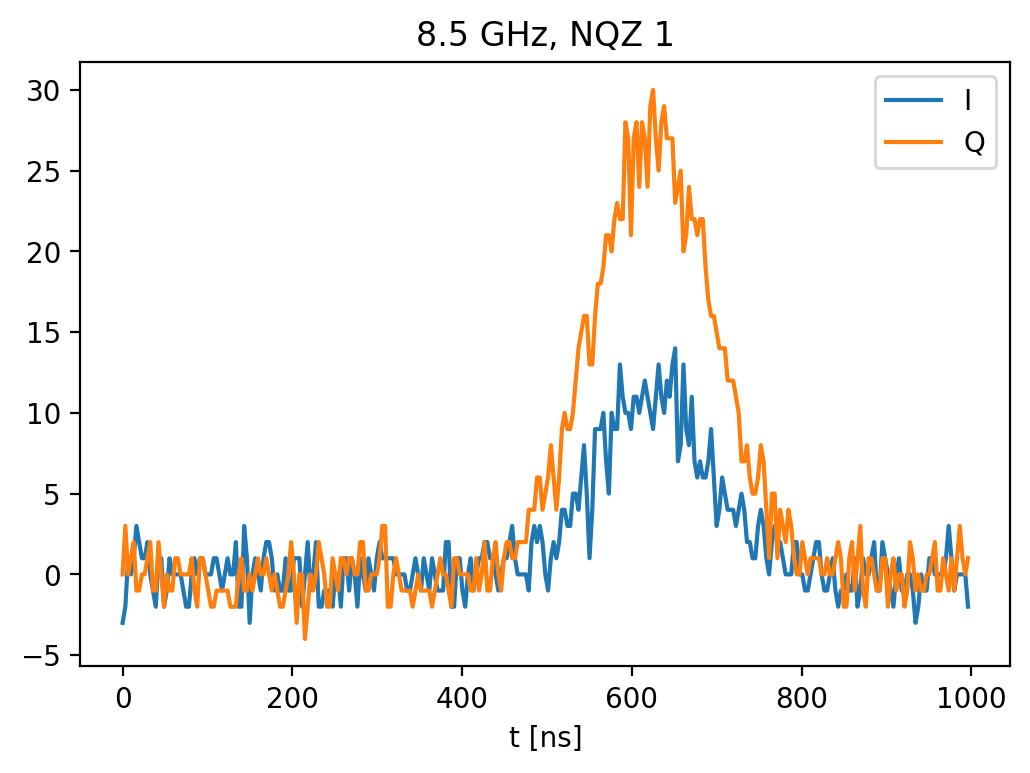

In [5]:
config={"ro_ch"       : [1],
        "ro_length"   : 1,
        "ro_offset"   : 0,
        
        "gen_ch"      : 2,        
        "pulse_length": 0.5,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 8500,
        "nqz"         : 1,
        
        "env_sigma"   : 0.1,
        "env_length"  : 0.4,
        "env_name"    : 'gauss',  
        
        "reps"        : 1,
       }


prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

# Plot Captured Data.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

yi = iq_list[0][0]
yq = iq_list[0][1]
x = ts*np.arange(len(iq_list[0][0]))

plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.legend(['I','Q']);  
plt.title("8.5 GHz, NQZ 1")

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, '8.5 GHz, NQZ 2')

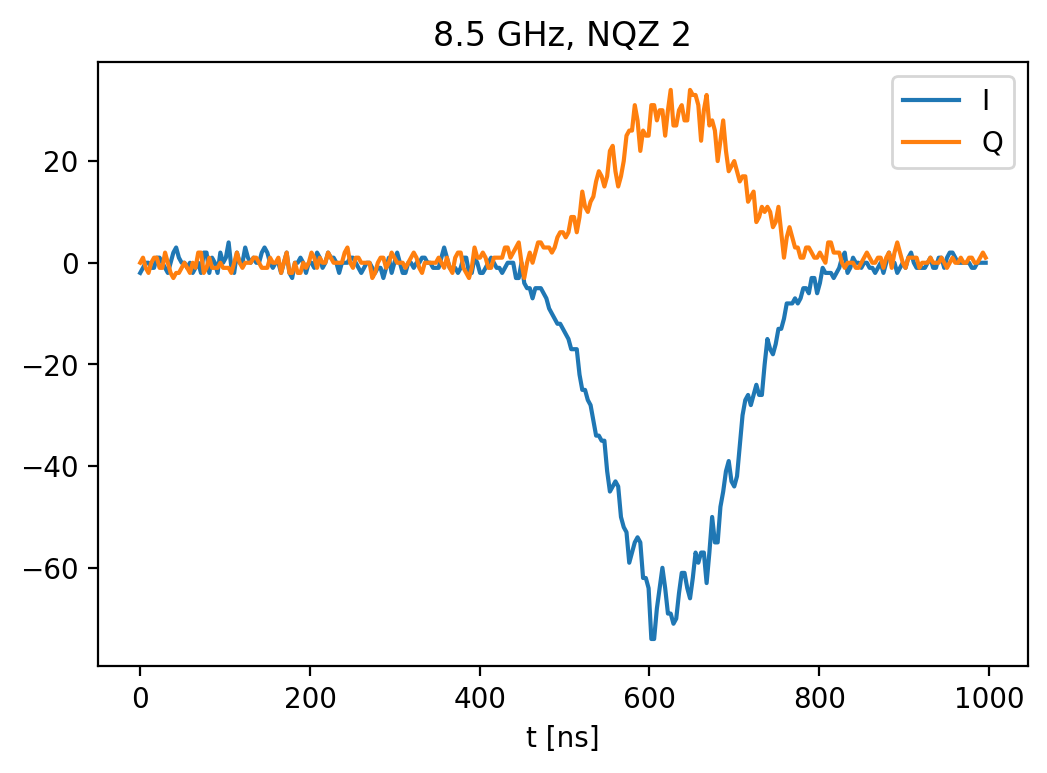

In [6]:
config={"ro_ch"       : [1],
        "ro_length"   : 1,
        "ro_offset"   : 0,
        
        "gen_ch"      : 2,        
        "pulse_length": 0.5,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 8500,
        "nqz"         : 2,
        
        "env_sigma"   : 0.1,
        "env_length"  : 0.4,
        "env_name"    : 'gauss',  
        
        "reps"        : 1,
       }


prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True)

# Plot Captured Data.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['readouts'][config['ro_ch'][0]]['fs']/8
ts = 1000*1/fs

yi = iq_list[0][0]
yq = iq_list[0][1]
x = ts*np.arange(len(iq_list[0][0]))

plt.plot(x,yi)
plt.plot(x,yq)
    
plt.xlabel('t [ns]');
plt.legend(['I','Q']);  
plt.title("8.5 GHz, NQZ 2")